In [1]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from random import seed
from sklearn import preprocessing
seed(1)

In [2]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

In [3]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
    
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
            math.exp(-1. * current_step * self.decay)

In [4]:
def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return (t1,t2,t3,t4)

In [5]:
class LSTM_V2(nn.Module):
    def __init__(self,n_features,seq_length, linear_output, memory_size,num_layers = 3):
        super(LSTM_V2, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.linear_outputs = linear_output
        self.batch_size = memory_size
        self.n_hidden = 200 
        self.num_layers = num_layers
        self.n_hidden_fc = 200
        
        self.lstm = nn.LSTM(self.n_features, self.n_hidden, self.num_layers, batch_first=True)
        self.fc   = nn.Linear(self.n_hidden,self.n_hidden_fc) 
        self.fc1  = nn.Linear(self.n_hidden_fc,self.linear_outputs)
        
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.n_hidden).to(device) #initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.n_hidden).to(device) #initial cell state
        lstm_hidden, _ = self.lstm(x, (h0,c0))  
        out = lstm_hidden[:, -1, :]
        out = self.fc(out)
        out = self.fc1(out)
        return out

In [6]:
class EnvManager():
    def __init__(self, device,environment):
        self.device = device
        #self.env = gym.make(environment).unwrapped
        self.env = gym.make(environment)
        self.env.reset()
        self.current_screen = None
        self.done = False
    
    def reset(self):
        self.env.reset()
        self.current_screen = None
        
    def close(self):
        self.env.close()
        
    def render(self, mode='human'):
        return self.env.render(mode)
        
    def num_actions_available(self):
        return self.env.action_space
        
    def take_action(self, action):   
        _, reward, self.done, _ = self.env.step([action.item()])
        return torch.tensor([reward], device=self.device)
    
    def just_starting(self):
        return self.current_screen is None
    
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
    
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
       
    def get_processed_screen(self):
        screen = em.render('rgb_array')
        rgb_weights = [0.2989, 0.5870, 0.1140]
        grayscale_image = np.dot(screen[...,:3], rgb_weights) 
        screen = grayscale_image.transpose((0, 1)) # PyTorch expects CHW
        #print(type(screen)) # numpy
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self, screen):
        screen_height = screen.shape[0]
        screen_width  = screen.shape[1]
        #print('screen height(top/bottom): ',screen_height)
        #print('screen height(left/right): ',screen_width)
        # Strip off top and bottom
        top = int(screen_height * 0.2)
        #print('top: ',top)
        bottom = int(screen_height * 0.8)
        #print('bottom: ',bottom)
        
        
        #strip off left/right
        left  = int(screen_width * 0.2)
        #print('left: ',left)
        right = int(screen_width * 0.8)
        #print('right: ',right)
        
        screen = screen[top:bottom, left:right]
        return screen
    
    
    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        
        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()
        ])
        
        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimension (BCHW)

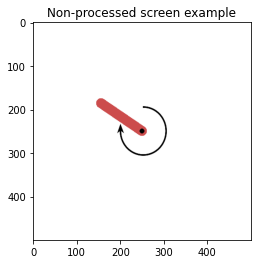

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
environment = 'Pendulum-v0'
em = EnvManager(device,environment)
em.reset()
screen = em.render('rgb_array')




plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen example')
plt.show()
em.close()

In [25]:
em.close()

tensor([[[[0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          ...,
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961]]]],
       device='cuda:0')


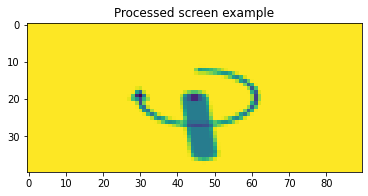

In [10]:
screen = em.get_processed_screen()
print(screen)
plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Processed screen example')
plt.show()
em.close()

In [22]:
screen = screen.flatten()
#for x in range(len(screen)):
#    print(screen[x])

In [67]:
import gym
env = gym.make('Pendulum-v0')
env.reset()
for _ in range(1000):
    env.render()
    #print(len(env.action_space.sample()))
    #print('next')
    #a = [-1.4]
    env.step(env.action_space.sample()) # take a random action
env.close()

In [68]:
#output is a continuous variable

In [12]:
em.close()

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')


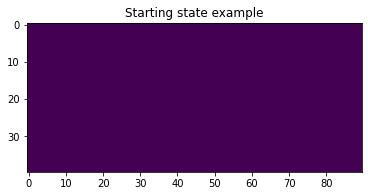

In [14]:
screen = em.get_state()
print(screen)
plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Starting state example')
plt.show()
em.close()

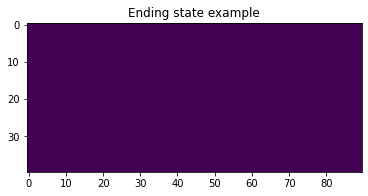

In [15]:
em.done = True
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Ending state example')
plt.show()
em.close()

In [28]:
em.close()

In [7]:
class Agent():
    def __init__(self, strategy, device):
        self.current_step = 0
        self.strategy = strategy
        self.device = device

    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.uniform(-2.0,2.0)# min max torque
            return torch.tensor([action]).to(self.device) # explore      
        else:
            with torch.no_grad():
                state = state.squeeze()
                state = state.unsqueeze(dim = 0)
                tensors = policy_net(state).to(self.device) # exploit
                return torch.tensor([tensors]).to(self.device)

In [83]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        states    = states.squeeze()
        outputs   = policy_net(states)
        actions   = actions.unsqueeze(dim = 1)
        out_      = torch.sub(outputs,actions)
        return out_
    
    @staticmethod        
    def get_next(target_net, next_states, rewards):          
        target_state_rewards_location = rewards.ge(torch.mean(rewards)).type(torch.bool)
        high_reward_state_locations = (target_state_rewards_location == False)
        high_reward_states = next_states[high_reward_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values = values.squeeze()
        values = values.unsqueeze(dim = 1)
        high_reward_states = high_reward_states.squeeze()
        values[high_reward_state_locations] = (target_net(high_reward_states).detach())
        return values

# Utility Function

In [ ]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(values)
    
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
          moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

# Main

In [84]:
batch_size = 200
gamma = 0.6
eps_start = 3
eps_end = 0.01
eps_decay = 0.00001
target_update = 2
memory_size = 10000
lr = 0.001
num_episodes = 40000 # run for more episodes for better results

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device: ',device)

device:  cuda


In [86]:
em = EnvManager(device,'Pendulum-v0')
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy,device)
memory = ReplayMemory(memory_size)
output_num = 1

policy_net = LSTM_V2(em.get_screen_width(),em.get_screen_height(), output_num, batch_size).to(device)
target_net = LSTM_V2(em.get_screen_width(),em.get_screen_height(), output_num, batch_size).to(device)
print('policy: ',policy_net)
print('target: ',target_net)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

policy:  LSTM_V2(
  (lstm): LSTM(90, 200, num_layers=3, batch_first=True)
  (fc): Linear(in_features=200, out_features=200, bias=True)
  (fc1): Linear(in_features=200, out_features=1, bias=True)
)
target:  LSTM_V2(
  (lstm): LSTM(90, 200, num_layers=3, batch_first=True)
  (fc): Linear(in_features=200, out_features=200, bias=True)
  (fc1): Linear(in_features=200, out_features=1, bias=True)
)


In [ ]:
episode_durations = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    avg = []
    loss_arr = []
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        avg.append(float(reward))
        next_state = em.get_state()
        
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values    = QValues.get_next(target_net, next_states, rewards)
            
            rewards_numpy    = rewards.unsqueeze(0)
            rewards_numpy    = rewards_numpy.cpu().numpy()
            rewards_numpy    = preprocessing.normalize(rewards_numpy)
            
            rewards_numpy    = np.squeeze(rewards_numpy)
            #convert to cuda tensor
            rewards          = torch.from_numpy(rewards_numpy).float().to(device)
            rewards          = rewards.unsqueeze(dim = 1)
            
            target_q_values  = (next_q_values * gamma) + rewards #value function
            
            current_q_values = current_q_values.to(torch.float32)
            target_q_values = target_q_values.to(torch.float32)
            
            loss = F.mse_loss(current_q_values, target_q_values)
            loss_arr.append(loss.item())
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()

        if em.done:
            break

    if episode % target_update == 0:
        print('updating target...')
        print('avg loss: ',sum(loss_arr)/len(loss_arr))
        print('avg rwrd: ',sum(avg)/len(avg))
        target_net.load_state_dict(policy_net.state_dict())
        
em.close()

updating target...
avg loss:  1.2911720275878906
avg rwrd:  -8.178244330679892
updating target...
avg loss:  0.823459198474884
avg rwrd:  -7.501118549601696
updating target...
avg loss:  0.43483925819396974
avg rwrd:  -4.900477440422254
updating target...
avg loss:  0.32535750925540924
avg rwrd:  -7.845398779860463
updating target...
avg loss:  0.19578700564801693
avg rwrd:  -5.338829369172345
updating target...
avg loss:  0.21600147139281034
avg rwrd:  -4.508709024399148


In [85]:
em.close()

In [39]:
Experience

__main__.Experience